# SIGMA \begin{equation*} \frac{\partial V}{\partial t} = \Psi + \Omega \end{equation*}
## **GODAS**

In [1]:
from dask_gateway import GatewayCluster

cluster = GatewayCluster()
cluster.scale(20)
#cluster.adapt(minimum=2, maximum=10)  # or cluster.scale(n) to a fixed size.
client = cluster.get_client()

In [2]:
client

Client Scheduler: gateway://traefik-gcp-uscentral1b-prod-dask-gateway.prod:80/prod.8fd2ec6b5cea4131a69914910a973bfc Dashboard: /services/dask-gateway/clusters/prod.8fd2ec6b5cea4131a69914910a973bfc/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [104]:
client.close()
cluster.close()

In [3]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
import fsspec
import xmitgcm
from xhistogram.xarray import histogram
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
%matplotlib inline
from fastjmd95 import jmd95numba

In [4]:
xr.set_options(display_style='text')

In [5]:
path = 'pangeo-tmp/stb2145/GODAS/datasets/'
ds = xr.open_zarr(gcsfs.GCSMap(path + 'ds_wg.zarr'))
coords = xr.open_zarr(gcsfs.GCSMap(path + 'coords_wg.zarr'))
cell_coords = xr.open_zarr(gcsfs.GCSMap(path + 'cell_coords_wg.zarr'))
cell_elements = xr.open_zarr(gcsfs.GCSMap(path + 'cell_elements_wg.zarr'))
surf_flux = xr.open_zarr(gcsfs.GCSMap(path + 'surf_flux.zarr'))
total_tend = xr.open_zarr(gcsfs.GCSMap(path + 'total_tend.zarr'))
tendency = xr.open_zarr(gcsfs.GCSMap(path + 'tendency.zarr'))
vel = xr.open_zarr(gcsfs.GCSMap(path + 'vel.zarr'))

In [6]:
surf_flux.time.isel(time=slice(0, -1))

<xarray.DataArray 'time' (time: 470)>
array(['1980-01-01T00:00:00.000000000', '1980-02-01T00:00:00.000000000',
       '1980-03-01T00:00:00.000000000', ..., '2018-12-01T00:00:00.000000000',
       '2019-01-01T00:00:00.000000000', '2019-02-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2019-02-01

In [7]:
#slicing datasets to finish Feb 1, 2019 so that time will line up at dVdt section 
ds = ds.isel(time=slice(0, -1))
surf_flux = surf_flux.isel(time=slice(0,-1))

# <font color='Green'>\begin{equation*} \sigma_2\ term \end{equation*} </font>

In [8]:
temp = (ds.pottmp - 273.15).load() #K to C
salt = (ds.salt * 1000).load() #kg/kg to g/kg

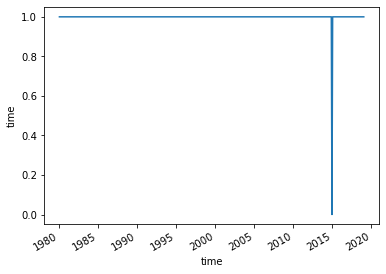

In [9]:
mask = salt.time != salt.time.sel(time='2015-01-01')
mask.plot()

In [10]:
salt_mask = salt.where(mask)

In [11]:
pref = 2000

In [12]:
sigma2 = xr.apply_ufunc(jmd95numba.rho, salt_mask, temp, pref,
                            output_dtypes=[salt_mask.dtype],
                            dask='parallelized').reset_coords(drop=True).load()

In [12]:
sigma2.coords

Coordinates:
  * lat      (lat) float32 -74.17 -73.83 -73.5 -73.17 ... -62.83 -62.5 -62.17
  * level    (level) float32 5.0 15.0 25.0 ... 3.483e+03 3.972e+03 4.478e+03
  * lon      (lon) float32 -65.5 -64.5 -63.5 -62.5 -61.5 ... 26.5 27.5 28.5 29.5
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2019-02-01

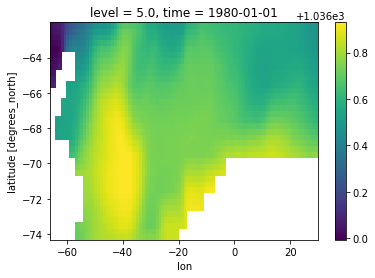

In [16]:
sigma2[0,0].plot()

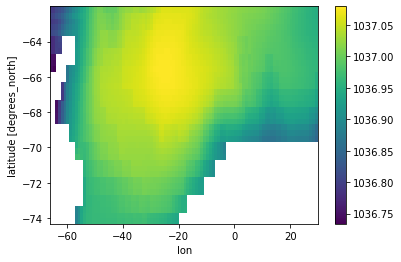

In [17]:
sigma2.mean(dim=['time', 'level']).plot()

(array([ 10.,  25.,  18.,  34.,  99., 184., 495., 599., 691., 587.]),
 array([1036.73354332, 1036.76813017, 1036.80271702, 1036.83730386,
        1036.87189071, 1036.90647756, 1036.94106441, 1036.97565126,
        1037.01023811, 1037.04482496, 1037.07941181]),
 <BarContainer object of 10 artists>)

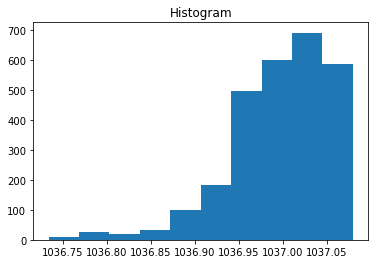

In [33]:
sigma2.mean(dim=['time', 'level']).plot.hist()

### Volume-weighted $\frac{\partial{\sigma_2}}{\partial t} =$ _tottend_truth_

In [29]:
cell_coords.cell_volume_wg.shape#[:-1, :-1, :].coords

(96, 37, 40)

In [30]:
total_tend.totttend.shape#.coords

(470, 39, 36, 95)

In [13]:
drhodt = xr.apply_ufunc(jmd95numba.drhodt, salt_mask, temp, pref,
                  output_dtypes=[temp.dtype], 
                  dask='parallelized').reset_coords(drop=True).load()

In [14]:
drhods = xr.apply_ufunc(jmd95numba.drhods, salt_mask, temp, pref,
                  output_dtypes=[salt_mask.dtype], 
                  dask='parallelized').reset_coords(drop=True).load()

In [20]:
drhodt.coords

Coordinates:
  * lat      (lat) float32 -74.17 -73.83 -73.5 -73.17 ... -62.83 -62.5 -62.17
  * level    (level) float32 5.0 15.0 25.0 ... 3.483e+03 3.972e+03 4.478e+03
  * lon      (lon) float32 -65.5 -64.5 -63.5 -62.5 -61.5 ... 26.5 27.5 28.5 29.5
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2019-02-01

In [21]:
drhods.coords

Coordinates:
  * lat      (lat) float32 -74.17 -73.83 -73.5 -73.17 ... -62.83 -62.5 -62.17
  * level    (level) float32 5.0 15.0 25.0 ... 3.483e+03 3.972e+03 4.478e+03
  * lon      (lon) float32 -65.5 -64.5 -63.5 -62.5 -61.5 ... 26.5 27.5 28.5 29.5
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2019-02-01

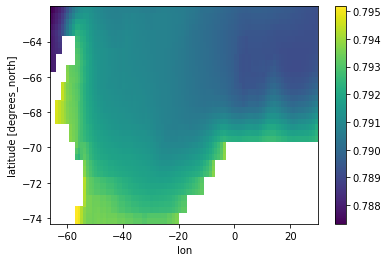

In [25]:
drhods.mean(dim=['level','time']).plot()

In [24]:
total_tend.totttend

<xarray.DataArray 'totttend' (time: 470, level: 40, lat: 37, lon: 96)>
dask.array<xarray-totttend, shape=(470, 40, 37, 96), dtype=float32, chunksize=(470, 40, 37, 96), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -74.17 -73.83 -73.5 -73.17 ... -62.83 -62.5 -62.17
  * level    (level) float32 5.0 15.0 25.0 ... 3.483e+03 3.972e+03 4.478e+03
  * lon      (lon) float32 -65.5 -64.5 -63.5 -62.5 -61.5 ... 26.5 27.5 28.5 29.5
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2019-02-01

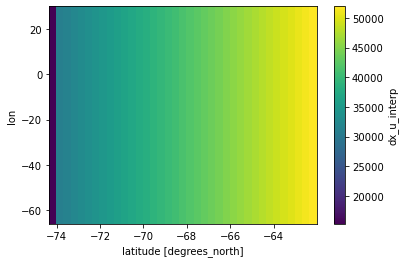

In [22]:
cell_elements.dx_u_interp.plot()

In [23]:
cell_elements.dx_u_interp * cell_elements.dy_u * cell_elements.dz

<xarray.DataArray (lon: 96, lat: 37, level: 40)>
dask.array<mul, shape=(96, 37, 40), dtype=float32, chunksize=(96, 37, 40), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -74.17 -73.83 -73.5 -73.17 ... -62.83 -62.5 -62.17
  * lon      (lon) float32 -65.5 -64.5 -63.5 -62.5 -61.5 ... 26.5 27.5 28.5 29.5
  * level    (level) float32 5.0 15.0 25.0 ... 3.483e+03 3.972e+03 4.478e+03

In [24]:
tendency.theta_tend.coords

Coordinates:
  * lat      (lat) float32 -74.17 -73.83 -73.5 -73.17 ... -62.83 -62.5 -62.17
  * level    (level) float32 5.0 15.0 25.0 ... 3.483e+03 3.972e+03 4.478e+03
  * lon      (lon) float32 -65.5 -64.5 -63.5 -62.5 -61.5 ... 26.5 27.5 28.5 29.5
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2019-02-01

In [25]:
drhodt.coords

Coordinates:
  * lat      (lat) float32 -74.17 -73.83 -73.5 -73.17 ... -62.83 -62.5 -62.17
  * level    (level) float32 5.0 15.0 25.0 ... 3.483e+03 3.972e+03 4.478e+03
  * lon      (lon) float32 -65.5 -64.5 -63.5 -62.5 -61.5 ... 26.5 27.5 28.5 29.5
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2019-02-01

In [15]:
vol = cell_elements.dx_u_interp * cell_elements.dy_u * cell_elements.dz

In [16]:
totttend_truth = (tendency.theta_tend * drhodt * vol).load()

In [17]:
totstend_truth = (tendency.salt_tend * drhods * vol).load()

In [18]:
delta_sigma = sigma2.isel(time=-1) - sigma2.isel(time=0)
total_time = (sigma2.time[-1] - sigma2.time[0]).astype('f8')*1e-9
totend_truth = (delta_sigma * vol) / total_time

In [180]:
coords.dt[:-1]

<xarray.DataArray 'dt' (time: 470)>
dask.array<getitem, shape=(470,), dtype=float32, chunksize=(470,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2019-02-01

Text(0.5, 1.0, 'sigma2 time dim vs sigma2 no time dim')

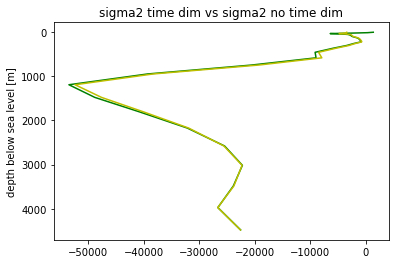

In [32]:
(sigma2.diff(dim='time',)*vol/coords.dt[:-1]).sum(dim=['lat', 'lon']).mean(dim='time').plot(y='level', yincrease=False, color='green')
totend_truth.sum(dim=['lat', 'lon']).plot(y='level', yincrease=False, color='y')
plt.title('sigma2 time dim vs sigma2 no time dim');

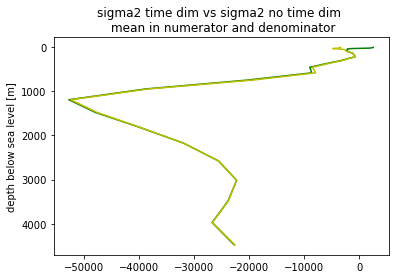

In [33]:
((sigma2.diff(dim='time',)*vol).mean(dim='time')/coords.dt[:-1].mean(dim='time')).sum(dim=['lat', 'lon']).plot(y='level', yincrease=False, 
                                                                                                               color='green')
totend_truth.sum(dim=['lat', 'lon']).plot(y='level', yincrease=False, color='y')
plt.title('sigma2 time dim vs sigma2 no time dim \n mean in numerator and denominator');

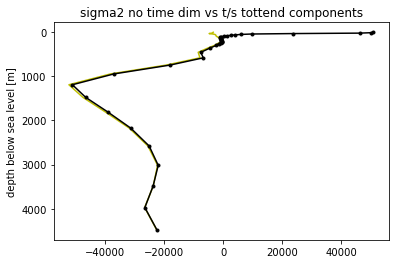

In [34]:
totend_truth.sum(dim=['lat', 'lon']).plot(y='level', yincrease=False, color='y')
(totttend_truth + totstend_truth).sum(dim=['lat', 'lon']).mean(dim='time').plot(y='level', yincrease=False, color='k', marker='.')
plt.title('sigma2 no time dim vs t/s tottend components');

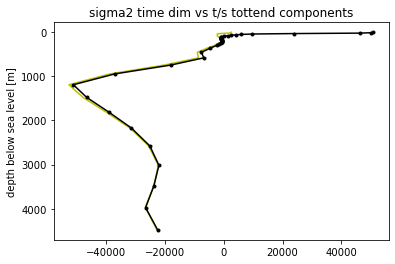

In [35]:
((sigma2.diff(dim='time',)*vol).mean(dim='time')/coords.dt[:-1].mean(dim='time')).sum(dim=['lat', 'lon']).plot(y='level', 
                                                                                                               yincrease=False, color='y')
(totttend_truth + totstend_truth).sum(dim=['lat', 'lon']).mean(dim='time').plot(y='level', yincrease=False, color='k', marker='.')
plt.title('sigma2 time dim vs t/s tottend components');

In [16]:
totend_truth = ((sigma2.diff(dim='time') * vol) / coords.dt[:-1]).load()

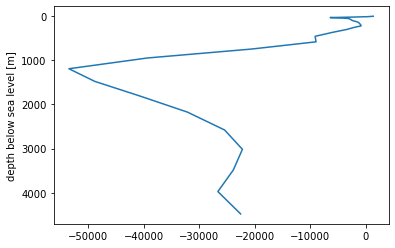

In [17]:
totend_truth.sum(['lat', 'lon']).mean(dim='time').plot(y='level', yincrease=False)

# <font color='Green'>\begin{equation*} \frac{\partial V}{\partial t} == \Omega_{tottend-\sigma-truth} + R1 \end{equation*} </font>

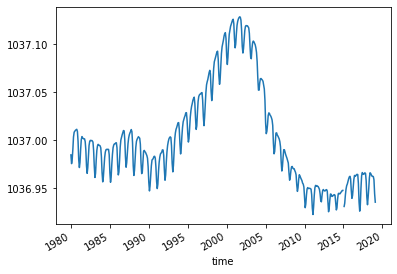

In [38]:
#looks strange but it's similar to ECCO considering the shorter time period
#density avged over volume gets denser in middle of the year (AA winter) and lighter around spring/summer
sigma2.mean(dim=['lon', 'lat', 'level']).plot()

In [39]:
sigma2.min().values

array(1035.50696701)

In [40]:
sigma2.max().values

array(1037.28606099)

In [18]:
# define bins (make same as ECCO & SOSE)
delta_sigma = 0.01
sigma_bins = np.arange(1027.5, 1037.5, delta_sigma)

In [42]:
sigma_bins.size

1000

In [43]:
sigma2.coords

Coordinates:
  * lat      (lat) float32 -74.17 -73.83 -73.5 -73.17 ... -62.83 -62.5 -62.17
  * level    (level) float32 5.0 15.0 25.0 ... 3.483e+03 3.972e+03 4.478e+03
  * lon      (lon) float32 -65.5 -64.5 -63.5 -62.5 -61.5 ... 26.5 27.5 28.5 29.5
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2019-02-01

In [44]:
vol.coords

Coordinates:
  * lat      (lat) float32 -74.17 -73.83 -73.5 -73.17 ... -62.83 -62.5 -62.17
  * lon      (lon) float32 -65.5 -64.5 -63.5 -62.5 -61.5 ... 26.5 27.5 28.5 29.5
  * level    (level) float32 5.0 15.0 25.0 ... 3.483e+03 3.972e+03 4.478e+03

In [19]:
sigma_dist = histogram(sigma2.rename('sigma2'), bins=[sigma_bins],
                       weights=vol.fillna(0.), dim=['lon', 'lat', 'level']).load()

In [20]:
sigma_dist

<xarray.DataArray 'histogram_sigma2' (time: 470, sigma2_bin: 999)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * time        (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2019-02-01
  * sigma2_bin  (sigma2_bin) float64 1.028e+03 1.028e+03 ... 1.037e+03 1.037e+03

(1036.9, 1037.3)

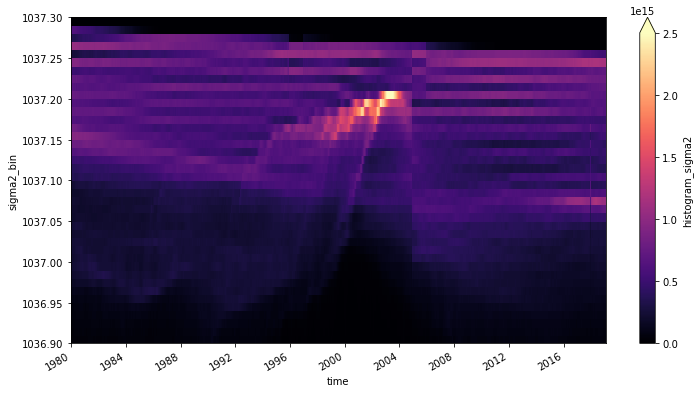

In [21]:
sigma_dist.where(mask).plot(x='time', figsize=(12, 6), vmax=2.5e15, cmap='magma')
plt.ylim(1036.9, 1037.3)

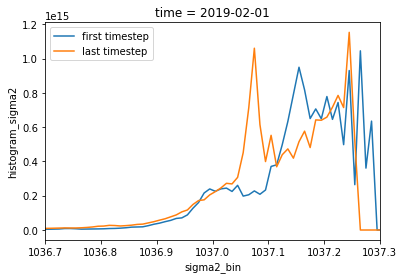

In [22]:
sigma_dist[0].plot(label='first timestep')
sigma_dist[-1].plot(label='last timestep')
plt.legend()
plt.xlim(1036.7, 1037.3);

(1037.5, 1036.4)

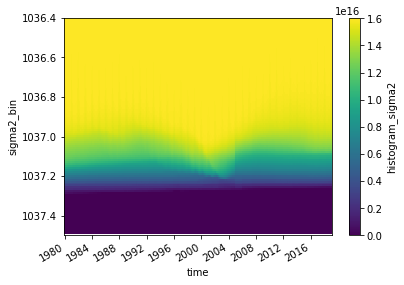

In [23]:
# cumulative volume
V = sigma_dist.isel(sigma2_bin=slice(None, None, -1)).cumsum(dim='sigma2_bin')
V.where(mask).transpose().plot()
plt.ylim(1037.5, 1036.4)

In [24]:
V

<xarray.DataArray 'histogram_sigma2' (time: 470, sigma2_bin: 999)>
array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.60297579e+16, 1.60297579e+16, 1.60297579e+16],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.60297579e+16, 1.60297579e+16, 1.60297579e+16],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.60297579e+16, 1.60297579e+16, 1.60297579e+16],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.60297579e+16, 1.60297579e+16, 1.60297579e+16],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.60297579e+16, 1.60297579e+16, 1.60297579e+16],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.60297579e+16, 1.60297579e+16, 1.60297579e+16]])
Coordinates:
  * time        (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2019-02-01
  * sigma2_bin  (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.028e+03 1.028e+03

(1037.5, 1036.5)

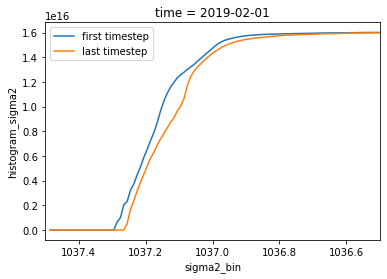

In [25]:
#waters with densities up to 1037.0 became lost volume and moved into denser sigma bins?
V[0].plot(label='first timestep')
V[-1].plot(label='last timestep')
plt.legend()
plt.xlim(1037.5, 1036.5)

In [26]:
delta_V = V.diff(dim='time')

In [28]:
delta_V

<xarray.DataArray 'histogram_sigma2' (time: 469, sigma2_bin: 999)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * time        (time) datetime64[ns] 1980-02-01 1980-03-01 ... 2019-02-01
  * sigma2_bin  (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.028e+03 1.028e+03

In [74]:
coords.dt[1:-1]

<xarray.DataArray 'dt' (time: 469)>
dask.array<getitem, shape=(469,), dtype=float32, chunksize=(469,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1980-02-01 1980-03-01 ... 2019-02-01

## $\frac{\partial \mathcal{V}}{\partial t}$

In [27]:
dVdt = delta_V / coords.dt[1:-1]

In [76]:
dVdt

<xarray.DataArray (time: 469, sigma2_bin: 999)>
dask.array<true_divide, shape=(469, 999), dtype=float64, chunksize=(469, 999), chunktype=numpy.ndarray>
Coordinates:
  * time        (time) datetime64[ns] 1980-02-01 1980-03-01 ... 2019-02-01
  * sigma2_bin  (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.028e+03 1.028e+03

(1035.5, 1037.3)

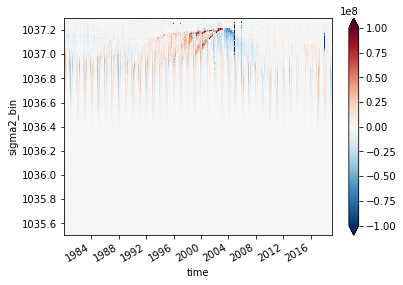

In [28]:
dVdt.where(mask).plot(x='time', vmax=1e8)
plt.ylim(1035.5, 1037.3)

(1035.5, 1037.3)

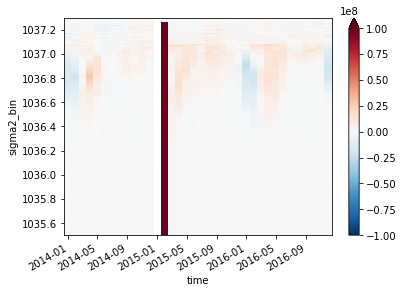

In [88]:
dVdt.where(mask).sel(time=slice('2014', '2016')).plot(x='time', vmax=1e8)
plt.ylim(1035.5, 1037.3)

## $\Omega_{total}$

In [90]:
totend_truth.coords

Coordinates:
  * time     (time) datetime64[ns] 1980-02-01 1980-03-01 ... 2019-02-01
  * lat      (lat) float32 -74.17 -73.83 -73.5 -73.17 ... -62.83 -62.5 -62.17
  * level    (level) float32 5.0 15.0 25.0 ... 3.483e+03 3.972e+03 4.478e+03
  * lon      (lon) float32 -65.5 -64.5 -63.5 -62.5 -61.5 ... 26.5 27.5 28.5 29.5

In [31]:
sigma2[1:].coords

Coordinates:
  * lat      (lat) float32 -74.17 -73.83 -73.5 -73.17 ... -62.83 -62.5 -62.17
  * level    (level) float32 5.0 15.0 25.0 ... 3.483e+03 3.972e+03 4.478e+03
  * lon      (lon) float32 -65.5 -64.5 -63.5 -62.5 -61.5 ... 26.5 27.5 28.5 29.5
  * time     (time) datetime64[ns] 1980-02-01 1980-03-01 ... 2019-02-01

In [29]:
omega_total = - histogram(sigma2[1:].rename('sigma2'), bins=[sigma_bins],
                          weights=totend_truth.fillna(0.),
                          dim=['lat', 'lon', 'level']) / (- delta_sigma)

In [30]:
omega_total.load()

<xarray.DataArray 'histogram_sigma2' (time: 469, sigma2_bin: 999)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * time        (time) datetime64[ns] 1980-02-01 1980-03-01 ... 2019-02-01
  * sigma2_bin  (sigma2_bin) float64 1.028e+03 1.028e+03 ... 1.037e+03 1.037e+03

In [31]:
dVdt

<xarray.DataArray (time: 469, sigma2_bin: 999)>
dask.array<true_divide, shape=(469, 999), dtype=float64, chunksize=(469, 999), chunktype=numpy.ndarray>
Coordinates:
  * time        (time) datetime64[ns] 1980-02-01 1980-03-01 ... 2019-02-01
  * sigma2_bin  (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.028e+03 1.028e+03

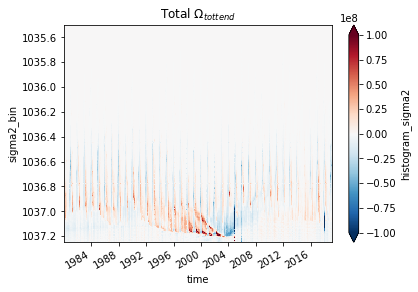

In [35]:
omega_total.plot(x='time', vmax=1e8)
plt.ylim(ymin=1037.25, ymax=1035.5)
plt.title(r'Total $\Omega_{tottend}$');

## <font color='Green'>\begin{equation*} R1 = \frac{\partial \mathcal{V}}{\partial t} - \Omega_{total} \end{equation*} (Discretization of sigma layers) </font>

In [36]:
dVdt.coords

Coordinates:
  * time        (time) datetime64[ns] 1980-02-01 1980-03-01 ... 2019-02-01
  * sigma2_bin  (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.028e+03 1.028e+03

In [37]:
omega_total.coords

Coordinates:
  * time        (time) datetime64[ns] 1980-02-01 1980-03-01 ... 2019-02-01
  * sigma2_bin  (sigma2_bin) float64 1.028e+03 1.028e+03 ... 1.037e+03 1.037e+03

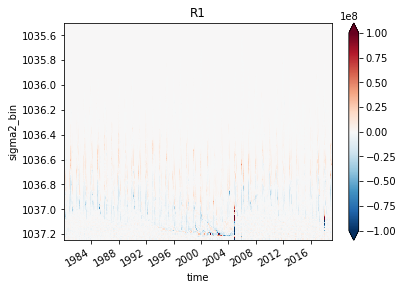

In [42]:
R1 = dVdt - omega_total

R1.where(mask).plot(x='time', vmax=1e8)
plt.ylim(ymin=1037.25, ymax=1035.5)
plt.title('R1');

In [44]:
dVdt

<xarray.DataArray (time: 469, sigma2_bin: 999)>
dask.array<true_divide, shape=(469, 999), dtype=float64, chunksize=(469, 999), chunktype=numpy.ndarray>
Coordinates:
  * time        (time) datetime64[ns] 1980-02-01 1980-03-01 ... 2019-02-01
  * sigma2_bin  (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.028e+03 1.028e+03

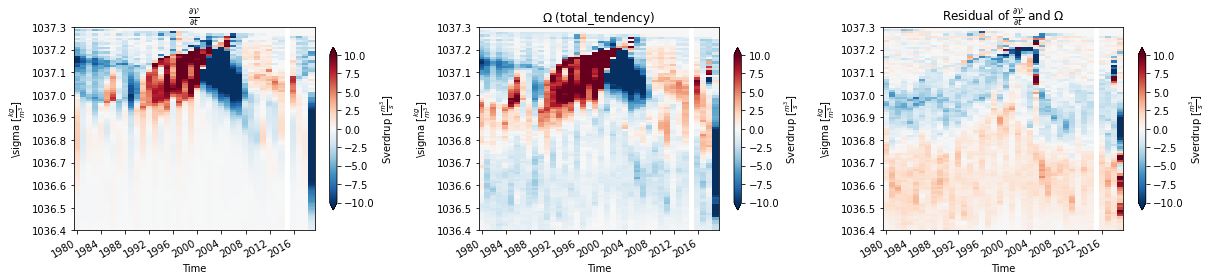

In [51]:
fig, (ax0,ax1,ax2) = plt.subplots(1, 3, figsize=(17, 4), sharex=True)

(dVdt/1e6).resample(time='AS').mean(dim='time').where(mask).plot(x='time', ax=ax0, vmax=10,
                                                     cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax0.set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')#, fontsize=14)
ax0.set_xlabel('Time')#, fontsize=14)
ax0.set_title(r'$\frac{\partial \mathcal{V}}{\partial t}$')#, fontsize=24)
ax0.set_ylim(1036.4, 1037.3)

(omega_total/1e6).resample(time='AS').mean(dim='time').where(mask).plot(x='time', ax=ax1, vmax=10,
                                                            cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax1.set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
ax1.set_xlabel('Time')#, fontsize=14)
ax1.set_title('$\Omega$ (total_tendency)')
ax1.set_ylim(1036.4, 1037.3)

(R1/1e6).resample(time='AS').mean(dim='time').where(mask).plot(x='time', ax=ax2, vmax=10,
                                                   cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax2.set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
ax2.set_xlabel('Time')
ax2.set_title(r'Residual of $\frac{\partial \mathcal{V}}{\partial t}$ and $\Omega$')
ax2.set_ylim(1036.4, 1037.3)

plt.tight_layout();

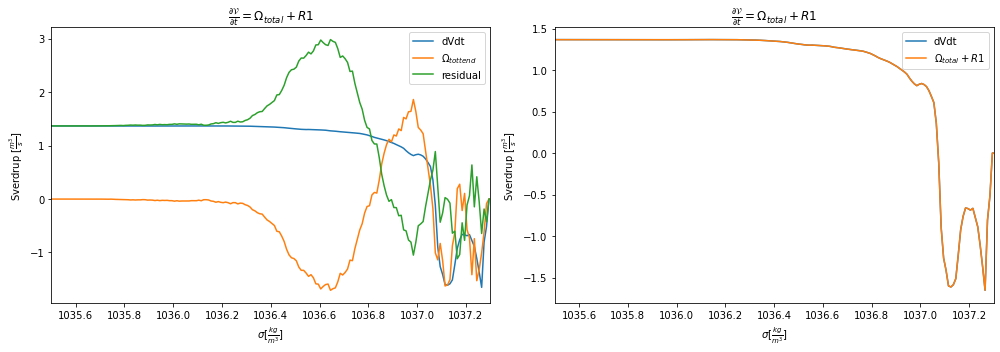

In [56]:
fig, (ax0,ax1) = plt.subplots(1, 2, figsize=(14, 5), sharex=True)

(dVdt/1e6).mean(dim='time').plot(label='dVdt', ax=ax0)
(omega_total/1e6).mean(dim='time').plot(label=r'$\Omega_{tottend}$', ax=ax0)
(R1/1e6).mean(dim='time').plot(label='residual', ax=ax0)
ax0.set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
ax0.set_xlabel(r'$\sigma [\frac{kg}{m^3}]$')
ax0.legend()
ax0.set_title(r'$\frac{\partial \mathcal{V}}{\partial t} = \Omega_{total} + R1$')
ax0.set_xlim(1035.5, 1037.3)

(dVdt/1e6).mean(dim='time').plot(label='dVdt', ax=ax1)
((omega_total + R1)/1e6).mean(dim='time').plot(label=r'$\Omega_{total} + R1$', ax=ax1)
ax1.set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
ax1.set_xlabel(r'$\sigma [\frac{kg}{m^3}]$')
ax1.legend()
ax1.set_title(r'$\frac{\partial \mathcal{V}}{\partial t} = \Omega_{total} + R1$')
ax1.set_xlim(1035.5, 1037.3)

plt.tight_layout();

## <span style='color:Green'> \begin{equation*} \Omega_{surf} \end{equation*}

In [58]:
surf_flux#.load()

<xarray.Dataset>
Dimensions:             (lat: 37, level: 40, lon: 96, time: 470)
Coordinates:
  * lat                 (lat) float32 -74.17 -73.83 -73.5 ... -62.5 -62.17
  * level               (level) float32 5.0 15.0 25.0 ... 3.972e+03 4.478e+03
  * lon                 (lon) float32 -65.5 -64.5 -63.5 -62.5 ... 27.5 28.5 29.5
  * time                (time) datetime64[ns] 1980-01-01 ... 2019-02-01
Data variables:
    surf_flux_conv_slt  (time, level, lat, lon) float32 dask.array<chunksize=(12, 40, 37, 96), meta=np.ndarray>
    surf_flux_conv_th   (time, level, lat, lon) float32 dask.array<chunksize=(12, 40, 37, 96), meta=np.ndarray>
    surf_flux_slt       (time, lat, lon) float32 dask.array<chunksize=(12, 37, 96), meta=np.ndarray>
    surf_flux_th        (time, lat, lon) float32 dask.array<chunksize=(12, 37, 96), meta=np.ndarray>

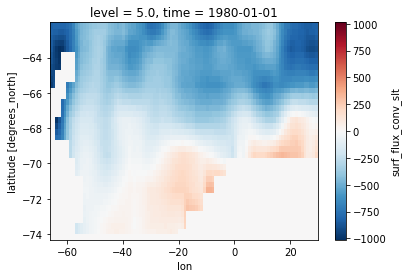

In [59]:
surf_flux.surf_flux_conv_slt[0,0].plot()

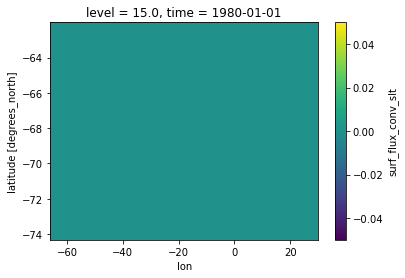

In [60]:
surf_flux.surf_flux_conv_slt[0,1].plot()

In [62]:
surf_flux.surf_flux_conv_slt[1:]

<xarray.DataArray 'surf_flux_conv_slt' (time: 469, level: 40, lat: 37, lon: 96)>
dask.array<getitem, shape=(469, 40, 37, 96), dtype=float32, chunksize=(12, 40, 37, 96), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -74.17 -73.83 -73.5 -73.17 ... -62.83 -62.5 -62.17
  * level    (level) float32 5.0 15.0 25.0 ... 3.483e+03 3.972e+03 4.478e+03
  * lon      (lon) float32 -65.5 -64.5 -63.5 -62.5 -61.5 ... 26.5 27.5 28.5 29.5
  * time     (time) datetime64[ns] 1980-02-01 1980-03-01 ... 2019-02-01

In [63]:
surf_flux.surf_flux_conv_th[1:]

<xarray.DataArray 'surf_flux_conv_th' (time: 469, level: 40, lat: 37, lon: 96)>
dask.array<getitem, shape=(469, 40, 37, 96), dtype=float32, chunksize=(12, 40, 37, 96), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -74.17 -73.83 -73.5 -73.17 ... -62.83 -62.5 -62.17
  * level    (level) float32 5.0 15.0 25.0 ... 3.483e+03 3.972e+03 4.478e+03
  * lon      (lon) float32 -65.5 -64.5 -63.5 -62.5 -61.5 ... 26.5 27.5 28.5 29.5
  * time     (time) datetime64[ns] 1980-02-01 1980-03-01 ... 2019-02-01

In [66]:
sigma2[1:].coords

Coordinates:
  * lat      (lat) float32 -74.17 -73.83 -73.5 -73.17 ... -62.83 -62.5 -62.17
  * level    (level) float32 5.0 15.0 25.0 ... 3.483e+03 3.972e+03 4.478e+03
  * lon      (lon) float32 -65.5 -64.5 -63.5 -62.5 -61.5 ... 26.5 27.5 28.5 29.5
  * time     (time) datetime64[ns] 1980-02-01 1980-03-01 ... 2019-02-01

In [67]:
omega_surf_TH = - (histogram(sigma2[1:].rename('sigma2'), bins=[sigma_bins],
                     weights=surf_flux.surf_flux_conv_th[1:].fillna(0.), dim=['lon', 'lat', 'level']) / (-delta_sigma))
omega_surf_TH.load()

omega_surf_SLT = - (histogram(sigma2[1:].rename('sigma2'), bins=[sigma_bins],
                     weights=surf_flux.surf_flux_conv_slt[1:].fillna(0.), dim=['lon', 'lat', 'level']) / (-delta_sigma))
omega_surf_SLT.load()

omega_surf = omega_surf_TH + omega_surf_SLT
omega_surf.load()

<xarray.DataArray 'histogram_sigma2' (time: 469, sigma2_bin: 999)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * time        (time) datetime64[ns] 1980-02-01 1980-03-01 ... 2019-02-01
  * sigma2_bin  (sigma2_bin) float64 1.028e+03 1.028e+03 ... 1.037e+03 1.037e+03

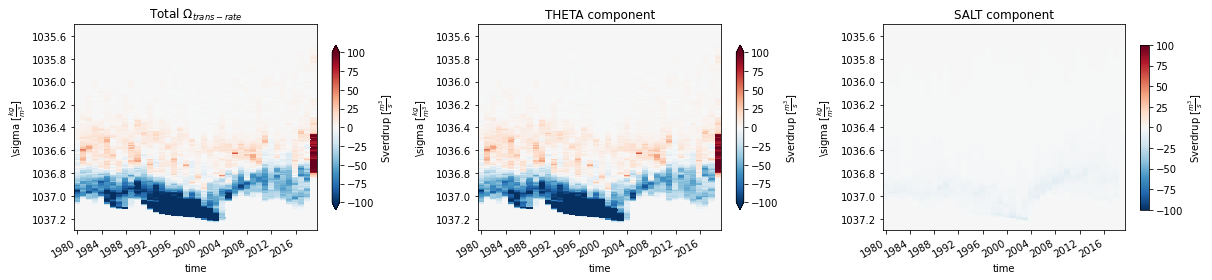

In [70]:
fig, (ax0,ax1,ax2) = plt.subplots(1,3, figsize=(17,4))

(omega_surf.resample(time='AS').mean()/1e6).plot(x='time', ax=ax0, vmax=100,
                                                       cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax0.set_ylim(1037.3, 1035.5)
ax0.set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
ax0.set_title(r'Total $\Omega_{trans-rate}$')

(omega_surf_TH.resample(time='AS').mean()/1e6).plot(x='time', ax=ax1, vmax=100,
                                                          cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax1.set_ylim(1037.3, 1035.5)
ax1.set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
ax1.set_title('THETA component')

(omega_surf_SLT.resample(time='AS').mean()/1e6).plot(x='time', ax=ax2, vmax=100,
                                                           cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax2.set_ylim(1037.3, 1035.5)
ax2.set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
ax2.set_title('SALT component')

plt.tight_layout();

## <font color='Green'> \begin{equation*} NO\ \Psi_{adv} = \Psi_{vel} + R2 \end{equation*} </font>

## <font color='Green'>\begin{equation*} \Psi_{vel} = \vec{\textbf{u}} \cdot \nabla \theta \end{equation*}</font>

In [71]:
import xgcm
grid = xgcm.Grid(ds, coords={'X': {'center': 'lon', 'right': 'lon_u'}, 
                             'Y': {'center': 'lat', 'right': 'lat_u'},
                             'T': {'center': 'time'},
                             'Z': {'center': 'level', 'right': 'level_w'}},
                     periodic=['X'])
grid

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   lon --> right
  * right    lon_u --> center
Y Axis (not periodic, boundary=None):
  * center   lat --> right
  * right    lat_u --> center
T Axis (not periodic, boundary=None):
  * center   time
Z Axis (not periodic, boundary=None):
  * center   level --> right
  * right    level_w --> center

In [72]:
ds

<xarray.Dataset>
Dimensions:    (lat: 37, lat_u: 37, level: 40, level_w: 40, lon: 96, lon_u: 96, time: 470)
Coordinates:
  * lat        (lat) float32 -74.17 -73.83 -73.5 -73.17 ... -62.83 -62.5 -62.17
  * lat_u      (lat_u) float32 -74.0 -73.67 -73.33 -73.0 ... -62.67 -62.33 -62.0
  * level      (level) float32 5.0 15.0 25.0 ... 3.483e+03 3.972e+03 4.478e+03
  * level_w    (level_w) float32 10.0 20.0 30.0 ... 4.225e+03 4.736e+03
  * lon        (lon) float32 -65.5 -64.5 -63.5 -62.5 ... 26.5 27.5 28.5 29.5
  * lon_u      (lon_u) float32 -65.0 -64.0 -63.0 -62.0 ... 27.0 28.0 29.0 30.0
  * time       (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2019-02-01
Data variables:
    dbss_obil  (time, lat, lon) float32 dask.array<chunksize=(12, 37, 96), meta=np.ndarray>
    dbss_obml  (time, lat, lon) float32 dask.array<chunksize=(12, 37, 96), meta=np.ndarray>
    dzdt       (time, level_w, lat, lon) float32 dask.array<chunksize=(4, 40, 37, 96), meta=np.ndarray>
    pottmp     (time, level, lat, lon) float32 dask.array<chunksize=(4, 40, 37, 96), meta=np.ndarray>
    salt       (time, level, lat, lon) float32 dask.array<chunksize=(4, 40, 37, 96), meta=np.ndarray>
    sltfl      (time, lat, lon) float32 dask.array<chunksize=(12, 37, 96), meta=np.ndarray>
    sshg       (time, lat, lon) float32 dask.array<chunksize=(12, 37, 96), meta=np.ndarray>
    thflx      (time, lat, lon) float32 dask.array<chunksize=(12, 37, 96), meta=np.ndarray>
    ucur       (time, level, lat_u, lon_u) float32 dask.array<chunksize=(4, 40, 37, 96), meta=np.ndarray>
    uflx       (time, lat_u, lon_u) float32 dask.array<chunksize=(12, 37, 96), meta=np.ndarray>
    vcur       (time, level, lat_u, lon_u) float32 dask.array<chunksize=(4, 40, 37, 96), meta=np.ndarray>
    vflx       (time, lat_u, lon_u) float32 dask.array<chunksize=(12, 37, 96), meta=np.ndarray>
Attributes:
    Conventions:      COARDS
    References:       https://www.esrl.noaa.gov/psd/data/gridded/data.godas.html
    comment:          NOTE:  THESE ARE THE BIAS CORRECTED GODAS FILES.
    creation_date:    Sat Dec 16 20:00:00 MDT 2006
    dataset_title:    NCEP Global Ocean Data Assimilation System (GODAS)
    grib_file:        godas.M.198001-12.grb
    history:          Created 2006/12 by Hoop
    html_BACKGROUND:  http://www.cpc.ncep.noaa.gov/products/GODAS/background....
    html_GODAS:       www.cpc.ncep.noaa.gov/products/GODAS
    html_REFERENCES:  http://www.cpc.ncep.noaa.gov/products/GODAS/background....
    sfcHeatFlux:      \nNote that the net surface heat flux are the total sur...
    time_comment:     The internal time stamp indicates the FIRST day of the ...
    title:            GODAS: Global Ocean Data Assimilation System

In [84]:
dx_interp = grid.interp(cell_elements.dx, 'Y', boundary='fill', keep_coords=True)

In [85]:
dx_interp

<xarray.DataArray 'mul-3e0f2598ee3e81114e61888b5b71a471' (lon_u: 96, lat_u: 37)>
dask.array<mul, shape=(96, 37), dtype=float32, chunksize=(96, 36), chunktype=numpy.ndarray>
Coordinates:
  * lon_u    (lon_u) float32 -65.0 -64.0 -63.0 -62.0 ... 27.0 28.0 29.0 30.0
  * lat_u    (lat_u) float32 -74.0 -73.67 -73.33 -73.0 ... -62.67 -62.33 -62.0

In [121]:
ds.ucur.coords

Coordinates:
  * lat_u    (lat_u) float32 -74.0 -73.67 -73.33 -73.0 ... -62.67 -62.33 -62.0
  * level    (level) float32 5.0 15.0 25.0 ... 3.483e+03 3.972e+03 4.478e+03
  * lon_u    (lon_u) float32 -65.0 -64.0 -63.0 -62.0 ... 27.0 28.0 29.0 30.0
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2019-02-01

In [120]:
cell_elements.dy.coords

Coordinates:
  * lat_u    (lat_u) float32 -74.0 -73.67 -73.33 -73.0 ... -62.67 -62.33 -62.0

In [124]:
cell_elements.dz

<xarray.DataArray 'dz' (level: 40)>
dask.array<xarray-dz, shape=(40,), dtype=float32, chunksize=(40,), chunktype=numpy.ndarray>
Coordinates:
  * level    (level) float32 5.0 15.0 25.0 ... 3.483e+03 3.972e+03 4.478e+03

In [122]:
ds.vcur.coords

Coordinates:
  * lat_u    (lat_u) float32 -74.0 -73.67 -73.33 -73.0 ... -62.67 -62.33 -62.0
  * level    (level) float32 5.0 15.0 25.0 ... 3.483e+03 3.972e+03 4.478e+03
  * lon_u    (lon_u) float32 -65.0 -64.0 -63.0 -62.0 ... 27.0 28.0 29.0 30.0
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2019-02-01

In [125]:
dx_interp.coords

Coordinates:
  * lon_u    (lon_u) float32 -65.0 -64.0 -63.0 -62.0 ... 27.0 28.0 29.0 30.0
  * lat_u    (lat_u) float32 -74.0 -73.67 -73.33 -73.0 ... -62.67 -62.33 -62.0

In [135]:
u_transport_right = (ds.ucur * cell_elements.dy * cell_elements.dz).isel(lon_u=-1)
u_transport_left = (ds.ucur * cell_elements.dy * cell_elements.dz).isel(lon_u=0)

v_transport = (ds.vcur * dx_interp * cell_elements.dz).isel(lat_u=-1)
#units: m^3/s

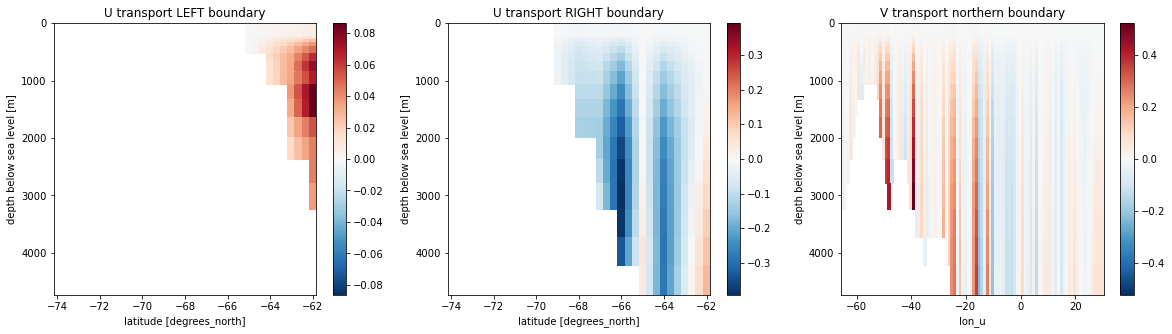

In [136]:
fig, (ax0,ax1,ax2) = plt.subplots(1,3, figsize=(20,5))

(u_transport_left[0]/1e6).plot(yincrease=False, ax=ax0)
ax0.set_title('U transport LEFT boundary')
(u_transport_right[0]/1e6).plot(yincrease=False, ax=ax1) 
ax1.set_title('U transport RIGHT boundary')
(v_transport[0]/1e6).plot(yincrease=False, ax=ax2)
ax2.set_title('V transport northern boundary');

In [140]:
u_transport_mean_value = (u_transport_right - u_transport_left).mean(dim='time').sum()/1e6
u_transport_mean_value.load()

<xarray.DataArray ()>
array(-14.027356, dtype=float32)

In [ ]:
u_transport_mean_value = (u_transport_right.sum(dim=['lat_u', 'level']) -
                          u_transport_left.sum(dim=['lat_u', 'level'])).mean(dim='time')/1e6
u_transport_mean_value.load()

In [134]:
v_transport_mean_value = (v_transport).mean(dim='time').sum()/1e6
v_transport_mean_value.load()

<xarray.DataArray ()>
array(25.774149, dtype=float32)
Coordinates:
    lat_u    float32 -62.0

In [138]:
residual = u_transport_mean_value + v_transport_mean_value
residual

<xarray.DataArray ()>
array(11.746793, dtype=float32)
Coordinates:
    lat_u    float32 -62.0

In [143]:
sigma2.coords

Coordinates:
  * lat      (lat) float32 -74.17 -73.83 -73.5 -73.17 ... -62.83 -62.5 -62.17
  * level    (level) float32 5.0 15.0 25.0 ... 3.483e+03 3.972e+03 4.478e+03
  * lon      (lon) float32 -65.5 -64.5 -63.5 -62.5 -61.5 ... 26.5 27.5 28.5 29.5
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2019-02-01

In [144]:
sigma_interp = grid.interp(sigma2, ['X', 'Y'], boundary='fill', keep_coords=True)

In [146]:
sigma_interp.coords

Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2019-02-01
  * level    (level) float32 5.0 15.0 25.0 ... 3.483e+03 3.972e+03 4.478e+03
  * lat_u    (lat_u) float32 -74.0 -73.67 -73.33 -73.0 ... -62.67 -62.33 -62.0
  * lon_u    (lon_u) float32 -65.0 -64.0 -63.0 -62.0 ... 27.0 28.0 29.0 30.0

In [147]:
sigma_at_u_right = sigma_interp.isel(lon_u=-1)
sigma_at_u_left = sigma_interp.isel(lon_u=0)
sigma_at_v = sigma_interp.isel(lat_u=-1)

In [151]:
v_transport[1:].coords

Coordinates:
    lat_u    float32 -62.0
  * level    (level) float32 5.0 15.0 25.0 ... 3.483e+03 3.972e+03 4.478e+03
  * lon_u    (lon_u) float32 -65.0 -64.0 -63.0 -62.0 ... 27.0 28.0 29.0 30.0
  * time     (time) datetime64[ns] 1980-02-01 1980-03-01 ... 2019-02-01

In [152]:
sigma_at_v[1:].coords

Coordinates:
  * time     (time) datetime64[ns] 1980-02-01 1980-03-01 ... 2019-02-01
  * level    (level) float32 5.0 15.0 25.0 ... 3.483e+03 3.972e+03 4.478e+03
    lat_u    float32 -62.0
  * lon_u    (lon_u) float32 -65.0 -64.0 -63.0 -62.0 ... 27.0 28.0 29.0 30.0

In [153]:
#this is the delta function part of the equation above
u_binned_right = histogram(sigma_at_u_right[1:].rename('sigma2'), bins=[sigma_bins],
                           weights=u_transport_right[1:].fillna(0.), dim=['level', 'lat_u'])

In [154]:
u_binned_left = histogram(sigma_at_u_left[1:].rename('sigma2'), bins=[sigma_bins],
                          weights=u_transport_left[1:].fillna(0.), dim=['level', 'lat_u'])

In [156]:
v_binned = histogram(sigma_at_v[1:].rename('sigma2'), bins=[sigma_bins],
                     weights=v_transport[1:].fillna(0.), dim=['level', 'lon_u'])

In [157]:
u_binned_right.load()

<xarray.DataArray 'histogram_sigma2' (time: 469, sigma2_bin: 999)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * time        (time) datetime64[ns] 1980-02-01 1980-03-01 ... 2019-02-01
  * sigma2_bin  (sigma2_bin) float64 1.028e+03 1.028e+03 ... 1.037e+03 1.037e+03

In [158]:
u_binned_left.load()

<xarray.DataArray 'histogram_sigma2' (time: 469, sigma2_bin: 999)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * time        (time) datetime64[ns] 1980-02-01 1980-03-01 ... 2019-02-01
  * sigma2_bin  (sigma2_bin) float64 1.028e+03 1.028e+03 ... 1.037e+03 1.037e+03

In [159]:
v_binned.load()

<xarray.DataArray 'histogram_sigma2' (time: 469, sigma2_bin: 999)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * time        (time) datetime64[ns] 1980-02-01 1980-03-01 ... 2019-02-01
  * sigma2_bin  (sigma2_bin) float64 1.028e+03 1.028e+03 ... 1.037e+03 1.037e+03

(1037.3, 1036.4)

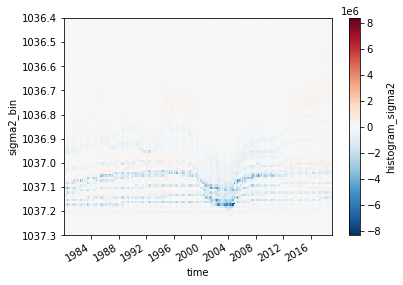

In [161]:
(u_binned_right+u_binned_left+v_binned).plot(y='sigma2_bin')
plt.ylim(1037.3, 1036.4)

In [162]:
#`isel` is letting cumsum act in reverse order (from densenst to lightest)
psi_vel = - (u_binned_right 
             - u_binned_left 
             + v_binned).isel(sigma2_bin=slice(None, None, -1)).cumsum(dim='sigma2_bin')
psi_vel.load()

<xarray.DataArray 'histogram_sigma2' (time: 469, sigma2_bin: 999)>
array([[      -0.        ,       -0.        ,       -0.        , ...,
        14364120.41660309, 14364120.41660309, 14364120.41660309],
       [      -0.        ,       -0.        ,       -0.        , ...,
         7607012.98042297,  7607012.98042297,  7607012.98042297],
       [      -0.        ,       -0.        ,       -0.        , ...,
         6856569.73955917,  6856569.73955917,  6856569.73955917],
       ...,
       [      -0.        ,       -0.        ,       -0.        , ...,
        24277045.66781616, 24277045.66781616, 24277045.66781616],
       [      -0.        ,       -0.        ,       -0.        , ...,
        20199990.54214478, 20199990.54214478, 20199990.54214478],
       [      -0.        ,       -0.        ,       -0.        , ...,
        17745529.8565979 , 17745529.8565979 , 17745529.8565979 ]])
Coordinates:
  * time        (time) datetime64[ns] 1980-02-01 1980-03-01 ... 2019-02-01
  * sigma2_bin  (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.028e+03 1.028e+03

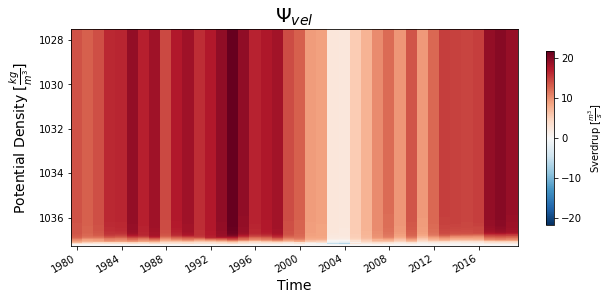

In [168]:
(psi_vel/1e6).resample(time='AS').mean(dim='time').plot(x='time', figsize=(10,4),
                                                        cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
plt.ylabel(r'Potential Density $[\frac{kg}{m^3}]$', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.title('$\Psi_{vel}$', fontsize=20)
plt.ylim(1037.3, 1027.5);

(1035.5, 1037.5)

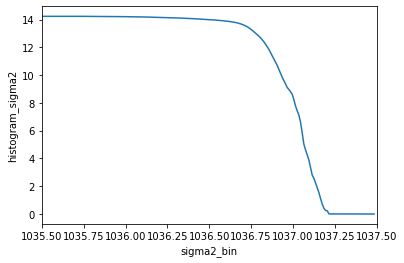

In [169]:
(psi_vel/1e6).mean(dim='time').plot()
plt.xlim(1035.5, 1037.5)

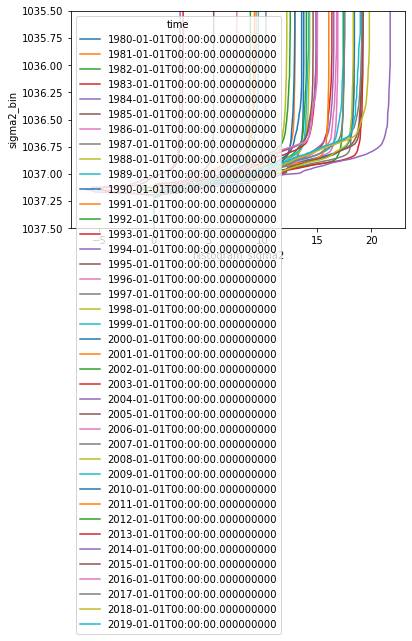

In [170]:
(psi_vel/1e6).resample(time='AS').mean(dim='time').plot.line(y='sigma2_bin');#, add_legend=True)
plt.ylim(1037.5, 1035.5);

## NO R2 = $\Psi_{adv} - \Psi_{vel}$ (Numerical Mixing)

# <font color='Green'>\begin{equation*} \Omega_{tottend-truth} = \Psi_{vel} + \Omega_{surf} + R2 \end{equation*} </font>

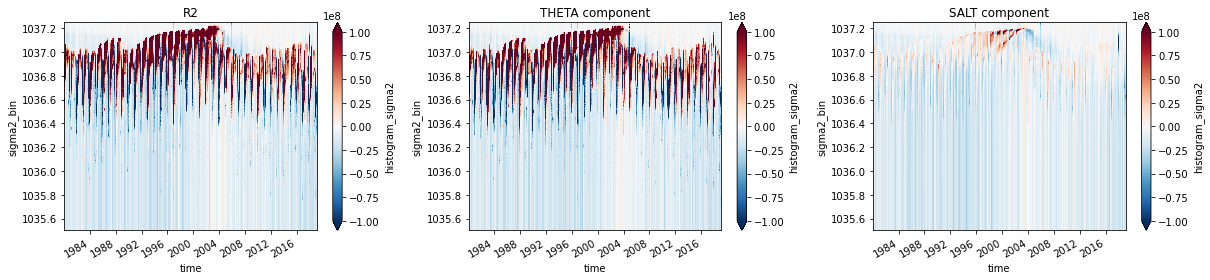

In [171]:
R2 = omega_total - psi_vel - omega_surf
R2_th = omega_total - psi_vel - omega_surf_TH
R2_slt = omega_total - psi_vel - omega_surf_SLT

fig, (ax0,ax1,ax2) = plt.subplots(1,3, figsize=(17,4))

R2.plot(x='time', vmax=1e8, ax=ax0)
ax0.set_ylim(ymax=1037.25, ymin=1035.5)
ax0.set_title('R2')

R2_th.plot(x='time', vmax=1e8, ax=ax1)
ax1.set_ylim(ymax=1037.25, ymin=1035.5)
ax1.set_title('THETA component')

R2_slt.plot(x='time', vmax=1e8, ax=ax2)
ax2.set_ylim(ymax=1037.25, ymin=1035.5)
ax2.set_title('SALT component')

plt.tight_layout();

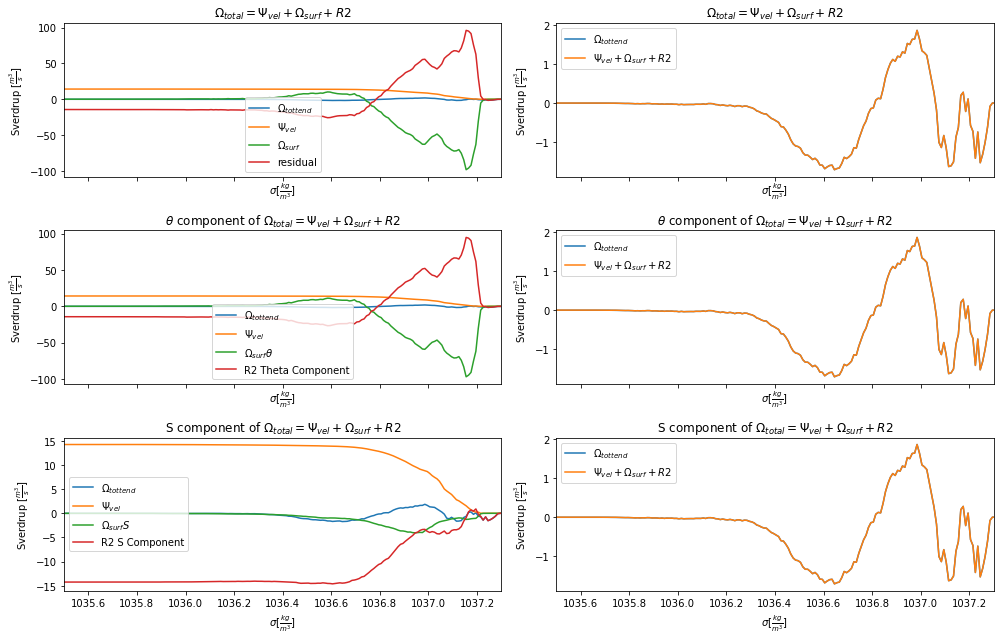

In [172]:
fig, axes = plt.subplots(3, 2, figsize=(14, 9), sharex=True)

(omega_total/1e6).mean(dim='time').plot(label=r'$\Omega_{tottend}$', ax=axes[0,0])
(psi_vel/1e6).mean(dim='time').plot(label=r'$\Psi_{vel}$', ax=axes[0,0])
(omega_surf/1e6).mean(dim='time').plot(label=r'$\Omega_{surf}$', ax=axes[0,0])
(R2/1e6).mean(dim='time').plot(label='residual', ax=axes[0,0])
axes[0,0].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[0,0].set_xlabel(r'$\sigma [\frac{kg}{m^3}]$')
axes[0,0].legend()
axes[0,0].set_title(r'$\Omega_{total} = \Psi_{vel} + \Omega_{surf} + R2$')
axes[0,0].set_xlim(1035.5, 1037.3)

(omega_total/1e6).mean(dim='time').plot(label=r'$\Omega_{tottend}$', ax=axes[0,1])
((psi_vel + omega_surf + R2)/1e6).mean(dim='time').plot(label=r'$\Psi_{vel} + \Omega_{surf} + R2$', ax=axes[0,1])
axes[0,1].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[0,1].set_xlabel(r'$\sigma [\frac{kg}{m^3}]$')
axes[0,1].legend()
axes[0,1].set_title(r'$\Omega_{total} = \Psi_{vel} + \Omega_{surf} + R2$')
axes[0,1].set_xlim(1035.5, 1037.3)

(omega_total/1e6).mean(dim='time').plot(label=r'$\Omega_{tottend}$', ax=axes[1,0])
(psi_vel/1e6).mean(dim='time').plot(label=r'$\Psi_{vel}$', ax=axes[1,0])
(omega_surf_TH/1e6).mean(dim='time').plot(label=r'$\Omega_{surf} \theta$', ax=axes[1,0])
(R2_th/1e6).mean(dim='time').plot(label='R2 Theta Component', ax=axes[1,0])
axes[1,0].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[1,0].set_xlabel(r'$\sigma [\frac{kg}{m^3}]$')
axes[1,0].legend()
axes[1,0].set_title(r'$\theta$ component of $\Omega_{total} = \Psi_{vel} + \Omega_{surf} + R2$')
axes[1,0].set_xlim(1035.5, 1037.3)

(omega_total/1e6).mean(dim='time').plot(label=r'$\Omega_{tottend}$', ax=axes[1,1])
((psi_vel + omega_surf_TH + R2_th)/1e6).mean(dim='time').plot(label=r'$\Psi_{vel} + \Omega_{surf} + R2$', ax=axes[1,1])
axes[1,1].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[1,1].set_xlabel(r'$\sigma [\frac{kg}{m^3}]$')
axes[1,1].legend()
axes[1,1].set_title(r'$\theta$ component of $\Omega_{total} = \Psi_{vel} + \Omega_{surf} + R2$')
axes[1,1].set_xlim(1035.5, 1037.3)

(omega_total/1e6).mean(dim='time').plot(label=r'$\Omega_{tottend}$', ax=axes[2,0])
(psi_vel/1e6).mean(dim='time').plot(label=r'$\Psi_{vel}$', ax=axes[2,0])
(omega_surf_SLT/1e6).mean(dim='time').plot(label=r'$\Omega_{surf} S$', ax=axes[2,0])
(R2_slt/1e6).mean(dim='time').plot(label='R2 S Component', ax=axes[2,0])
axes[2,0].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[2,0].set_xlabel(r'$\sigma [\frac{kg}{m^3}]$')
axes[2,0].legend()
axes[2,0].set_title(r'S component of $\Omega_{total} = \Psi_{vel} + \Omega_{surf} + R2$')
axes[2,0].set_xlim(1035.5, 1037.3)

(omega_total/1e6).mean(dim='time').plot(label=r'$\Omega_{tottend}$', ax=axes[2,1])
((psi_vel + omega_surf_SLT + R2_slt)/1e6).mean(dim='time').plot(label=r'$\Psi_{vel} + \Omega_{surf} + R2$', ax=axes[2,1])
axes[2,1].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[2,1].set_xlabel(r'$\sigma [\frac{kg}{m^3}]$')
axes[2,1].legend()
axes[2,1].set_title(r'S component of $\Omega_{total} = \Psi_{vel} + \Omega_{surf} + R2$')
axes[2,1].set_xlim(1035.5, 1037.3)

plt.tight_layout();

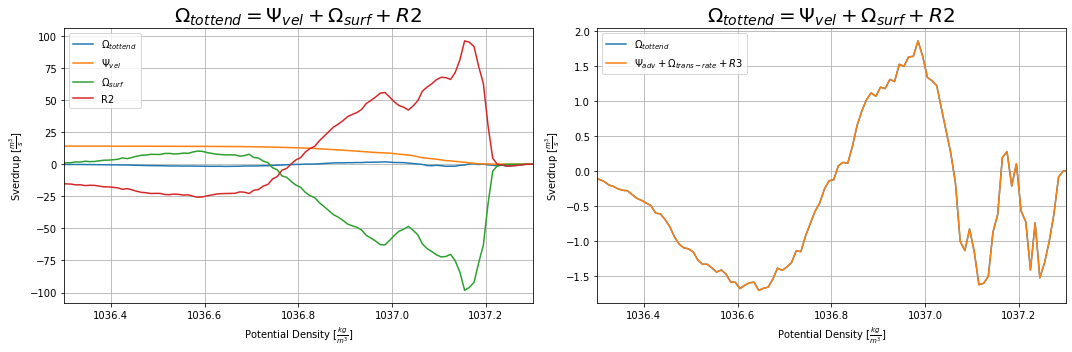

In [173]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 5), sharex=True)

(omega_total/1e6).mean(dim='time').plot(label=r'$\Omega_{tottend}$', ax=ax0)
(psi_vel/1e6).mean(dim='time').plot(label=r'$\Psi_{vel}$', ax=ax0)
(omega_surf/1e6).mean(dim='time').plot(label=r'$\Omega_{surf}$', ax=ax0)
(R2/1e6).mean(dim='time').plot(label='R2', ax=ax0)
ax0.set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
ax0.set_xlabel(r'Potential Density $[\frac{kg}{m^3}]$')
ax0.legend()
ax0.grid()
ax0.set_title(r'$\Omega_{tottend} = \Psi_{vel} + \Omega_{surf} + R2$', fontsize=20)
ax0.set_xlim(1036.3, 1037.3)

(omega_total/1e6).mean(dim='time').plot(label=r'$\Omega_{tottend}$', ax=ax1)
((psi_vel + omega_surf + R2)/1e6).mean(dim='time').plot(label=r'$\Psi_{adv}+\Omega_{trans-rate}+R3$', ax=ax1)
ax1.set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
ax1.set_xlabel(r'Potential Density $[\frac{kg}{m^3}]$')
ax1.legend()
ax1.grid()
ax1.set_title(r'$\Omega_{tottend} = \Psi_{vel} + \Omega_{surf} + R2$', fontsize=20)
ax1.set_xlim(1036.3, 1037.3)

plt.tight_layout();

(1037.5, 1036.5)

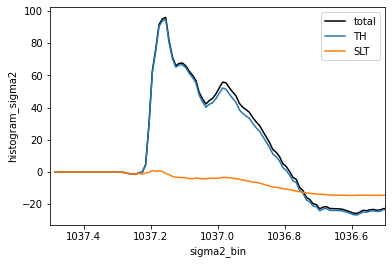

In [174]:
(R2/1e6).mean(dim='time').plot(color='k', label='total')
(R2_th/1e6).mean(dim='time').plot(label='TH')
(R2_slt/1e6).mean(dim='time').plot(label='SLT')
plt.legend()
plt.xlim(1037.5, 1036.5)

# <font color='Green'>\begin{equation*} \frac{\partial{V}}{\partial{t}} = \Psi_{vel} + \Omega_{surf} + R2 + R1\end{equation*} </font>

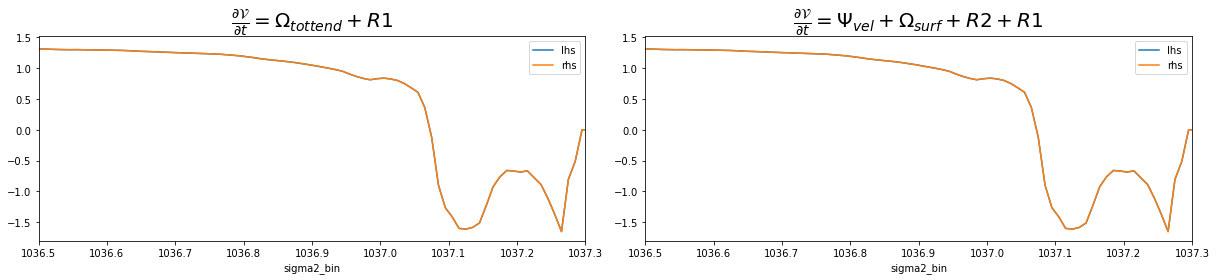

In [175]:
fig, (ax0,ax1) = plt.subplots(1, 2, figsize=(17,4))

(dVdt/1e6).mean(dim='time').plot(label='lhs', ax=ax0) 
((omega_total + R1)/1e6).mean(dim='time').plot(label='rhs', ax=ax0)
ax0.set_title(r'$\frac{\partial \mathcal{V}}{\partial t} = \Omega_{tottend} + R1$', fontsize=20, fontweight='bold')
ax0.legend()
ax0.set_xlim(1036.5, 1037.3)

(dVdt/1e6).mean(dim='time').plot(label='lhs', ax=ax1) 
((psi_vel + omega_surf + R2 + R1)/1e6).mean(dim='time').plot(label='rhs', ax=ax1)
ax1.set_title(r'$\frac{\partial \mathcal{V}}{\partial t} = \Psi_{vel} + \Omega_{surf} + R2 + R1$', fontsize=20, fontweight='bold')
ax1.legend()
ax1.set_xlim(1036.5, 1037.3)

plt.tight_layout();

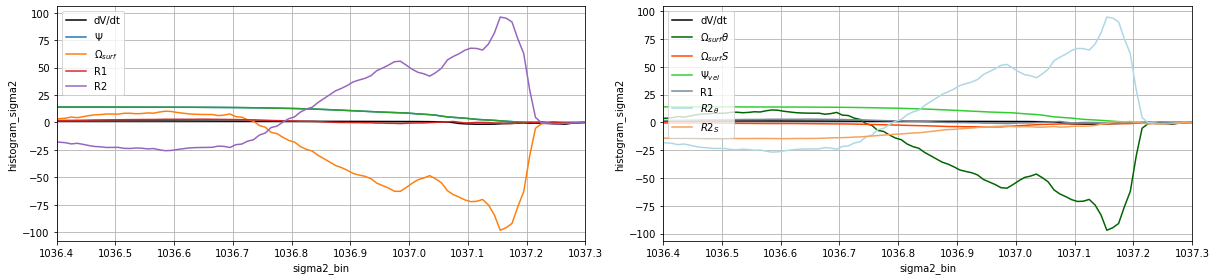

In [176]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(17, 4), sharex=True)

(dVdt/1e6).mean(dim='time').plot(label='dV/dt', color='k', ax=ax0)
(psi_vel/1e6).mean(dim='time').plot(label=r'$\Psi$', ax=ax0)
(omega_surf/1e6).mean(dim='time').plot(label=r'$\Omega_{surf}$', ax=ax0)
(psi_vel[1:-1]/1e6).mean(dim='time').plot(label=r'', ax=ax0)

(R1/1e6).mean(dim='time').plot(label='R1', ax=ax0)
(R2/1e6).mean(dim='time').plot(label='R2', ax=ax0)
ax0.legend()
ax0.grid()
ax0.set_xlim(1036.4, 1037.3)

(dVdt/1e6).mean(dim='time').plot(label='dV/dt', color='k', ax=ax1)
(omega_surf_TH/1e6).mean(dim='time').plot(label=r'$\Omega_{surf}\theta$', ax=ax1, color='darkgreen')
(omega_surf_SLT/1e6).mean(dim='time').plot(label=r'$\Omega_{surf}S$', ax=ax1, color='orangered')
(psi_vel/1e6).mean(dim='time').plot(label=r'$\Psi_{vel}$', ax=ax1, color='limegreen')
(R1/1e6).mean(dim='time').plot(label='R1', ax=ax1, color='lightslategray')
(R2_th/1e6).mean(dim='time').plot(label=r'$R2_{\theta}$', ax=ax1, color='lightblue')
(R2_slt/1e6).mean(dim='time').plot(label=r'$R2_S$', ax=ax1, color='sandybrown')
ax1.legend()
ax1.grid()
ax1.set_xlim(1036.4, 1037.3)
plt.tight_layout();